## Tải dữ liệu

### Subtask:
Tải tập dữ liệu 'diabetes_prediction_dataset.csv' từ Google Drive vào một PySpark DataFrame.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when, count, isnull
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline


**Reasoning**:
The user wants to load a CSV file into a PySpark DataFrame. This involves importing SparkSession, creating a SparkSession, mounting Google Drive, and then reading the CSV file using Spark.



In [ ]:
from pyspark.sql import SparkSession

# 1. Create a SparkSession object named spark
spark = SparkSession.builder.appName('DiabetesPrediction').getOrCreate()

# 2. Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Specify the full path to the 'diabetes_prediction_dataset.csv' file on your Google Drive
file_path = '/content/drive/MyDrive/BTL_KhaiPhaDuLieu/diabetes_prediction_dataset.csv'

# 4. Use spark.read.csv() to load the CSV file into a PySpark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the schema and first few rows of the DataFrame to verify loading
df.printSchema()
df.show(5)

Mounted at /content/drive
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|    

# Khám phá dữ liệu (EDA)



**Reasoning**:
The subtask requires performing Exploratory Data Analysis (EDA) on the PySpark DataFrame. This includes checking for missing values, examining the distribution of categorical and numerical features, and analyzing the class distribution of the target variable 'diabetes'. I will use PySpark functions to achieve these tasks in a single code block.



In [ ]:
# 1. Kiểm tra số lượng giá trị thiếu cho mỗi cột
print("\n### Kiểm tra giá trị thiếu ###")
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

# 2. In ra số lượng giá trị duy nhất và phân phối của các cột phân loại
categorical_cols = ['gender', 'smoking_history', 'hypertension', 'heart_disease']
print("\n### Phân phối cột phân loại ###")
for col_name in categorical_cols:
    print(f"\nPhân phối của '{col_name}':")
    df.groupBy(col_name).count().show()

# 3. Tính toán các thống kê mô tả cho các cột số
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
print("\n### Thống kê mô tả cho cột số ###")
df.select(numerical_cols).describe().show()

# 4. Xác định sự phân bố của biến mục tiêu 'diabetes'
print("\n### Phân bố biến mục tiêu 'diabetes' ###")
total_rows = df.count()
distribution_df = df.groupBy('diabetes').count().withColumn('percentage', (col('count') / total_rows) * 100)
distribution_df.show()



### Kiểm tra giá trị thiếu ###
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|gender|age|hypertension|heart_disease|smoking_history|bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|     0|  0|           0|            0|              0|  0|          0|                  0|       0|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+


### Phân phối cột phân loại ###

Phân phối của 'gender':
+------+-----+
|gender|count|
+------+-----+
|Female|58552|
| Other|   18|
|  Male|41430|
+------+-----+


Phân phối của 'smoking_history':
+---------------+-----+
|smoking_history|count|
+---------------+-----+
|    not current| 6447|
|         former| 9352|
|        No Info|35816|
|        current| 9286|
|          never|35095|
|           ever| 4004|
+---------------+-----+


Phân phối của 'hyperte

## Làm sạch và tiền xử lý dữ liệu

### Subtask:
Xử lý các giá trị không hợp lệ trong các cột phân loại và đảm bảo tính nhất quán của dữ liệu.


**Reasoning**:
The first instruction is to remove rows where the 'gender' column has a value of 'Other' to ensure data consistency, as these are a small number of records and could cause issues in modeling. The other instructions are confirmations based on previous EDA.



In [ ]:
# 1. Lọc bỏ các hàng có giá trị 'Other' trong cột 'gender'
df_cleaned = df.filter(col('gender') != 'Other')

# 2. In ra số lượng hàng sau khi lọc để xác nhận
print(f"Số lượng hàng trước khi lọc: {df.count()}")
print(f"Số lượng hàng sau khi lọc: {df_cleaned.count()}")

# 3. Xác nhận phân phối của cột 'gender' sau khi lọc
print("\nPhân phối của 'gender' sau khi lọc:")
df_cleaned.groupBy('gender').count().show()

# 4. Xác nhận không có giá trị thiếu (đã được kiểm tra trong EDA trước đó)
print("\nKiểm tra giá trị thiếu (xác nhận lại):")
df_cleaned.select([count(when(isnull(c), c)).alias(c) for c in df_cleaned.columns]).show()

# 5. Xác nhận kiểu dữ liệu (đã được kiểm tra trong EDA trước đó)
print("\nSchema của DataFrame sau khi làm sạch (xác nhận lại):")
df_cleaned.printSchema()


Số lượng hàng trước khi lọc: 100000
Số lượng hàng sau khi lọc: 99982

Phân phối của 'gender' sau khi lọc:
+------+-----+
|gender|count|
+------+-----+
|Female|58552|
|  Male|41430|
+------+-----+


Kiểm tra giá trị thiếu (xác nhận lại):
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|gender|age|hypertension|heart_disease|smoking_history|bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|     0|  0|           0|            0|              0|  0|          0|                  0|       0|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+


Schema của DataFrame sau khi làm sạch (xác nhận lại):
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nul

## Kỹ thuật đặc trưng (Feature Engineering)

### Subtask:
Chuyển đổi các biến phân loại sang định dạng số (sử dụng StringIndexer và OneHotEncoder), chuẩn hóa các biến số (sử dụng StandardScaler), và tập hợp tất cả các đặc trưng đã xử lý thành một cột vector duy nhất bằng VectorAssembler để chuẩn bị cho mô hình.


**Reasoning**:
The subtask requires performing feature engineering using PySpark ML transformations including StringIndexer, OneHotEncoder, VectorAssembler, and StandardScaler, combined into a Pipeline. This step will prepare the data for model training.



In [ ]:


# 1. Define categorical and numerical columns
categorical_cols = ['gender', 'smoking_history', 'hypertension', 'heart_disease']
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# 2. Create StringIndexer stages
indexer_stages = []
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed", handleInvalid="keep")
    indexer_stages.append(indexer)

# 3. Create OneHotEncoder stages
encoder_stages = []
for col_name in categorical_cols:
    encoder = OneHotEncoder(inputCol=col_name + "_indexed", outputCol=col_name + "_encoded", dropLast=True)
    encoder_stages.append(encoder)

# 4. Create VectorAssembler for numerical features
numerical_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="numerical_features"
)

# 5. Create StandardScaler for numerical features
scaler = StandardScaler(
    inputCol="numerical_features",
    outputCol="scaled_features",
    withStd=True,
    withMean=False
)

# 6. Create final VectorAssembler for all features
encoded_output_cols = [col_name + "_encoded" for col_name in categorical_cols]
feature_assembler = VectorAssembler(
    inputCols=encoded_output_cols + ["scaled_features"],
    outputCol="features"
)

# 7. Assemble all stages into a Pipeline
pipeline_stages = indexer_stages + encoder_stages + [numerical_assembler, scaler, feature_assembler]
pipeline = Pipeline(stages=pipeline_stages)

# 8. Fit the pipeline to the df_cleaned DataFrame
pipeline_model = pipeline.fit(df_cleaned)

# 9. Transform df_cleaned using the fitted pipeline
feature_vector_df = pipeline_model.transform(df_cleaned)

# 10. Display the schema and first few rows of the DataFrame to verify
print("\nSchema of feature_vector_df:")
feature_vector_df.printSchema()

print("\nFirst 5 rows of feature_vector_df:")
feature_vector_df.select("features", "diabetes").show(5, truncate=False)


Schema of feature_vector_df:
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- gender_indexed: double (nullable = false)
 |-- smoking_history_indexed: double (nullable = false)
 |-- hypertension_indexed: double (nullable = false)
 |-- heart_disease_indexed: double (nullable = false)
 |-- gender_encoded: vector (nullable = true)
 |-- smoking_history_encoded: vector (nullable = true)
 |-- hypertension_encoded: vector (nullable = true)
 |-- heart_disease_encoded: vector (nullable = true)
 |-- numerical_features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- features: vector (nullable = true)


First 5 rows of feature_vect

## Trực quan hóa tương quan

### Subtask:
Vẽ biểu đồ để trực quan hóa mối tương quan giữa các đặc trưng đầu vào và biến mục tiêu 'diabetes', có thể là một ma trận tương quan hoặc các biểu đồ tương quan khác.


**Reasoning**:
The subtask requires visualizing correlations between input features and the target variable 'diabetes'. This involves calculating and plotting a correlation heatmap for numerical and binary categorical features, and then plotting bar charts for the average diabetes prevalence across multi-valued categorical features. I will perform these steps within a single code block to complete the visualization requirement.



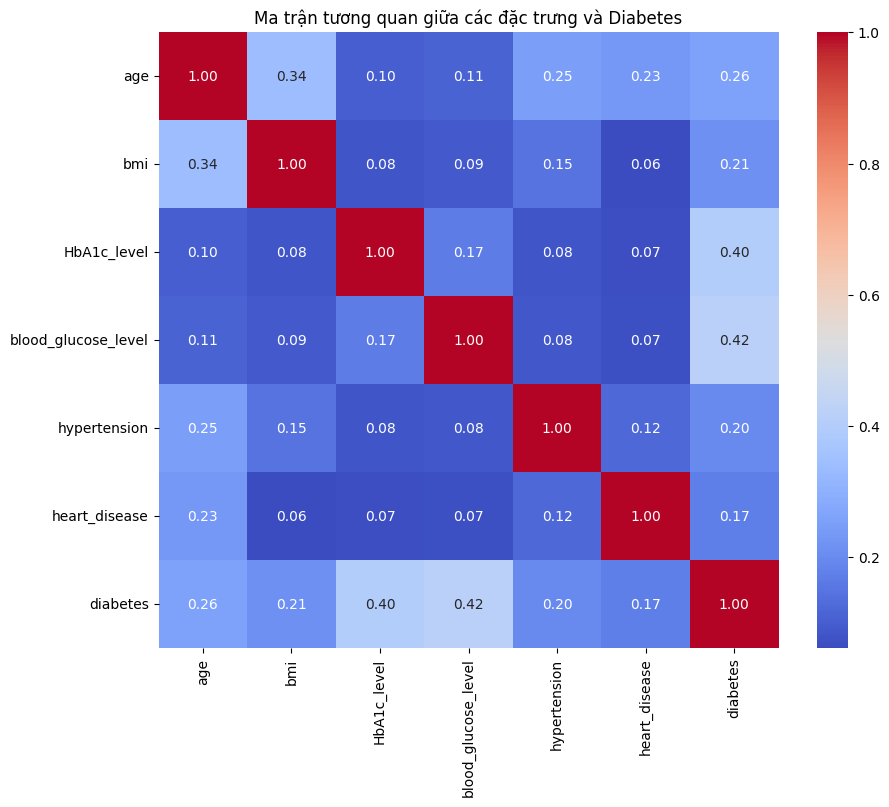

/tmp/ipython-input-278434158.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='avg(diabetes)', data=pd_diabetes_by_gender, palette='viridis')


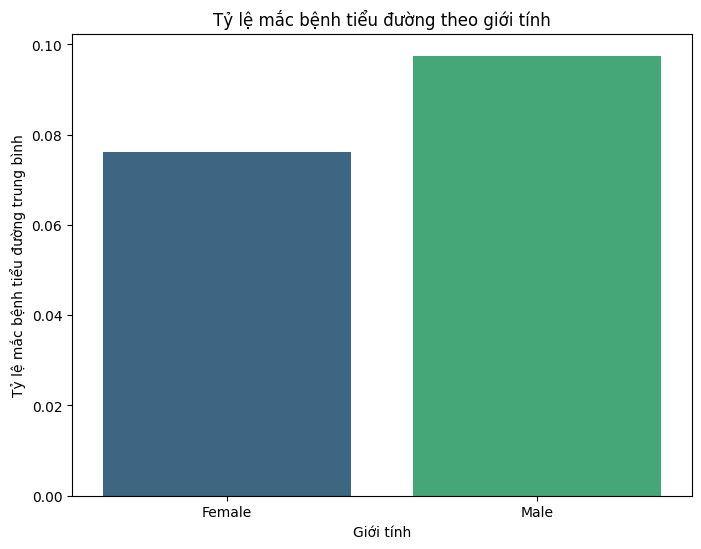

/tmp/ipython-input-278434158.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='smoking_history', y='avg(diabetes)', data=pd_diabetes_by_smoking, palette='magma')


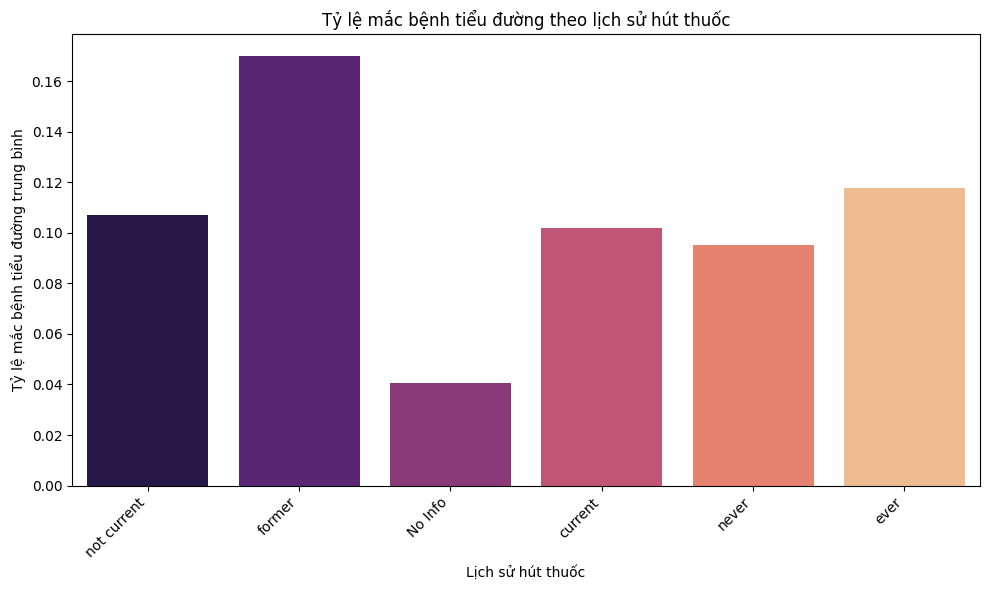

In [ ]:
# 1. Select numerical and binary categorical columns from df_cleaned
correlation_cols = [
    'age', 'bmi', 'HbA1c_level', 'blood_glucose_level',
    'hypertension', 'heart_disease', 'diabetes'
]
df_corr_subset = df_cleaned.select(correlation_cols)

# 2. Chuyển đổi tập hợp con của PySpark DataFrame này thành một Pandas DataFrame
pd_corr_df = df_corr_subset.toPandas()

# 3. Tính toán ma trận tương quan Pearson
correlation_matrix = pd_corr_df.corr(method='pearson')

# 4. Sử dụng thư viện seaborn và matplotlib.pyplot để vẽ một heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan giữa các đặc trưng và Diabetes')
plt.show()

# 5. Đối với các cột phân loại đa giá trị (gender, smoking_history):
# a. Nhóm df_cleaned theo từng cột và tính toán tỷ lệ mắc bệnh tiểu đường trung bình
# Gender vs Diabetes
diabetes_by_gender_spark = df_cleaned.groupBy('gender').agg({'diabetes': 'mean'})
# b. Chuyển đổi kết quả tổng hợp này thành các Pandas DataFrame
pd_diabetes_by_gender = diabetes_by_gender_spark.toPandas()

# Smoking History vs Diabetes
diabetes_by_smoking_spark = df_cleaned.groupBy('smoking_history').agg({'diabetes': 'mean'})
# b. Chuyển đổi kết quả tổng hợp này thành các Pandas DataFrame
pd_diabetes_by_smoking = diabetes_by_smoking_spark.toPandas()

# c. Sử dụng seaborn.barplot để trực quan hóa tỷ lệ mắc bệnh tiểu đường trung bình
# Plot for Gender
plt.figure(figsize=(8, 6))
sns.barplot(x='gender', y='avg(diabetes)', data=pd_diabetes_by_gender, palette='viridis')
plt.title('Tỷ lệ mắc bệnh tiểu đường theo giới tính')
plt.xlabel('Giới tính')
plt.ylabel('Tỷ lệ mắc bệnh tiểu đường trung bình')
plt.show()

# Plot for Smoking History
plt.figure(figsize=(10, 6))
sns.barplot(x='smoking_history', y='avg(diabetes)', data=pd_diabetes_by_smoking, palette='magma')
plt.title('Tỷ lệ mắc bệnh tiểu đường theo lịch sử hút thuốc')
plt.xlabel('Lịch sử hút thuốc')
plt.ylabel('Tỷ lệ mắc bệnh tiểu đường trung bình')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Reasoning**:
The previous code generated `FutureWarning` messages from Seaborn regarding the use of `palette` without specifying a `hue` argument in `sns.barplot`. To resolve this and ensure compatibility with newer Seaborn versions, I will explicitly set `hue` to the x-axis variable and add `legend=False` to the `barplot` calls.



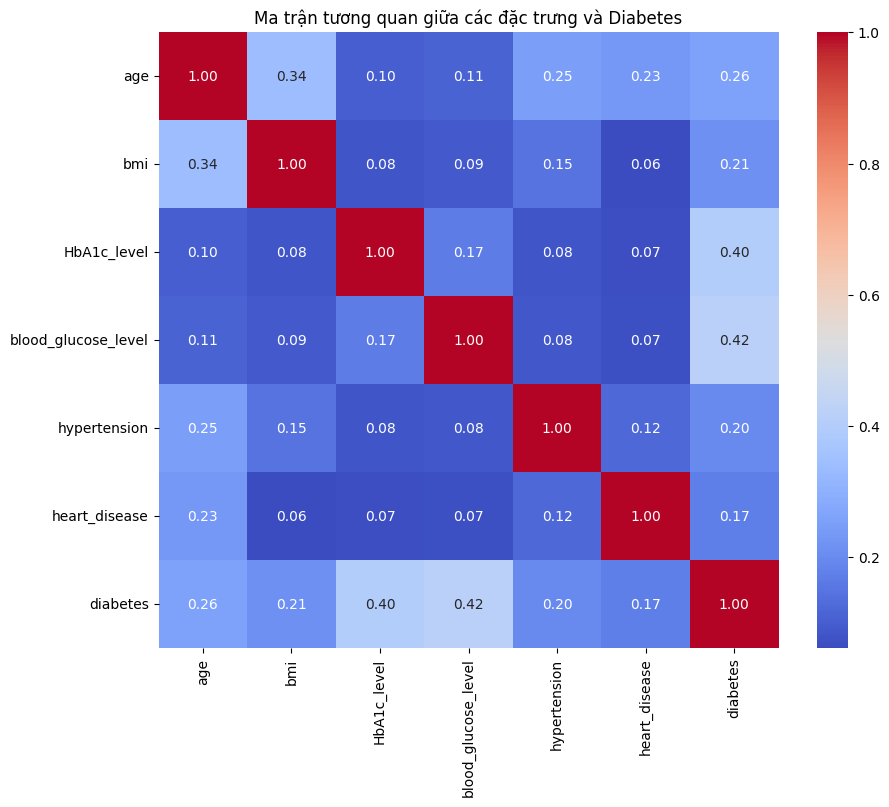

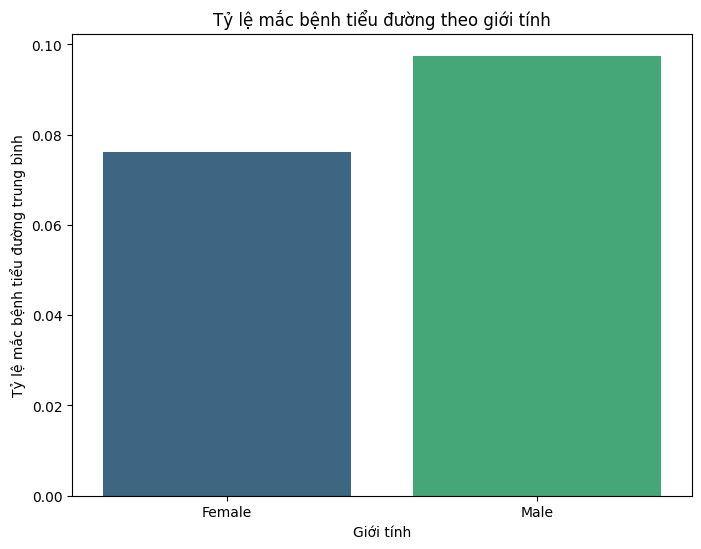

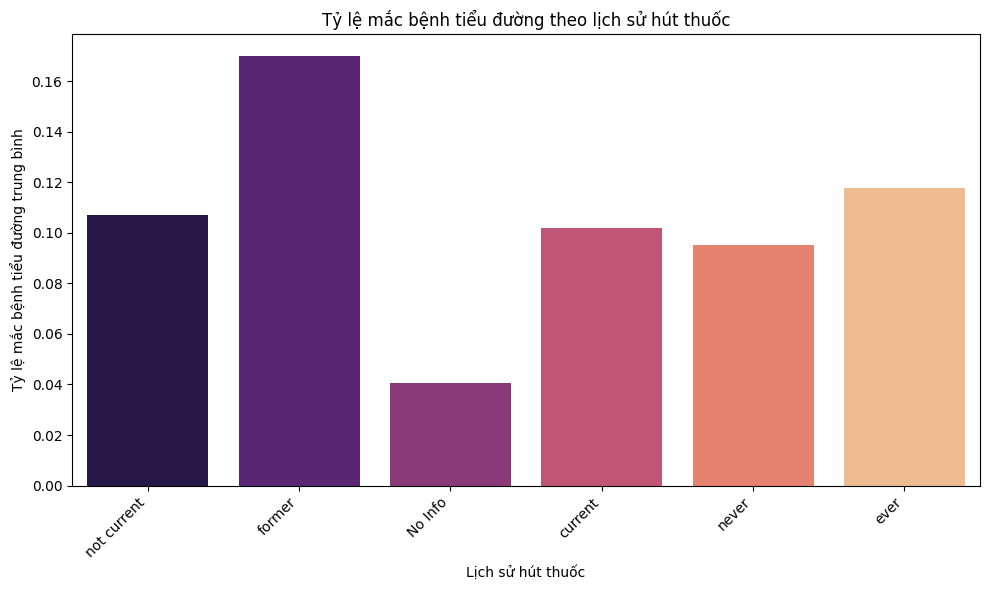

In [ ]:
# 1. Select numerical and binary categorical columns from df_cleaned
correlation_cols = [
    'age', 'bmi', 'HbA1c_level', 'blood_glucose_level',
    'hypertension', 'heart_disease', 'diabetes'
]
df_corr_subset = df_cleaned.select(correlation_cols)

# 2. Chuyển đổi tập hợp con của PySpark DataFrame này thành một Pandas DataFrame
pd_corr_df = df_corr_subset.toPandas()

# 3. Tính toán ma trận tương quan Pearson
correlation_matrix = pd_corr_df.corr(method='pearson')

# 4. Sử dụng thư viện seaborn và matplotlib.pyplot để vẽ một heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan giữa các đặc trưng và Diabetes')
plt.show()

# 5. Đối với các cột phân loại đa giá trị (gender, smoking_history):
# a. Nhóm df_cleaned theo từng cột và tính toán tỷ lệ mắc bệnh tiểu đường trung bình
# Gender vs Diabetes
diabetes_by_gender_spark = df_cleaned.groupBy('gender').agg({'diabetes': 'mean'})
# b. Chuyển đổi kết quả tổng hợp này thành các Pandas DataFrame
pd_diabetes_by_gender = diabetes_by_gender_spark.toPandas()

# Smoking History vs Diabetes
diabetes_by_smoking_spark = df_cleaned.groupBy('smoking_history').agg({'diabetes': 'mean'})
# b. Chuyển đổi kết quả tổng hợp này thành các Pandas DataFrame
pd_diabetes_by_smoking = diabetes_by_smoking_spark.toPandas()

# c. Sử dụng seaborn.barplot để trực quan hóa tỷ lệ mắc bệnh tiểu đường trung bình
# Plot for Gender
plt.figure(figsize=(8, 6))
sns.barplot(x='gender', y='avg(diabetes)', data=pd_diabetes_by_gender, palette='viridis', hue='gender', legend=False)
plt.title('Tỷ lệ mắc bệnh tiểu đường theo giới tính')
plt.xlabel('Giới tính')
plt.ylabel('Tỷ lệ mắc bệnh tiểu đường trung bình')
plt.show()

# Plot for Smoking History
plt.figure(figsize=(10, 6))
sns.barplot(x='smoking_history', y='avg(diabetes)', data=pd_diabetes_by_smoking, palette='magma', hue='smoking_history', legend=False)
plt.title('Tỷ lệ mắc bệnh tiểu đường theo lịch sử hút thuốc')
plt.xlabel('Lịch sử hút thuốc')
plt.ylabel('Tỷ lệ mắc bệnh tiểu đường trung bình')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Chia dữ liệu huấn luyện và kiểm tra

### Subtask:
Chia PySpark DataFrame đã được tiền xử lý thành các tập dữ liệu huấn luyện (training set) và kiểm tra (test set) để đánh giá mô hình.


**Reasoning**:
The subtask requires splitting the pre-processed PySpark DataFrame (`feature_vector_df`) into training and test sets using an 80/20 ratio and a seed for reproducibility, then printing the counts of the resulting DataFrames.



In [ ]:
from pyspark.sql import DataFrame

# 1. Chia feature_vector_df thành tập huấn luyện (80%) và tập kiểm tra (20%)
# Đảm bảo đặt một seed để đảm bảo khả năng tái lập
training_data, test_data = feature_vector_df.randomSplit([0.8, 0.2], seed=42)

# 2. In số lượng hàng của từng DataFrame mới để xác nhận việc chia tách
print(f"Số lượng hàng trong tập huấn luyện: {training_data.count()}")
print(f"Số lượng hàng trong tập kiểm tra: {test_data.count()}")

Số lượng hàng trong tập huấn luyện: 79886
Số lượng hàng trong tập kiểm tra: 20096


## Xây dựng Pipeline ML

### Subtask:
Xây dựng một PySpark ML Pipeline bao gồm tất cả các bước kỹ thuật đặc trưng và mô hình hồi quy logistic (LogisticRegression) làm bộ ước lượng cuối cùng.


**Reasoning**:
The subtask requires constructing a full PySpark ML Pipeline by combining the existing feature engineering stages with a Logistic Regression model, which will be the final estimator in the pipeline.



In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# 1. Instantiate a LogisticRegression model
lr = LogisticRegression(featuresCol='features', labelCol='diabetes', maxIter=10)

# 2. Add the LogisticRegression model to the end of the pipeline_stages list
#    The pipeline_stages list was created in the feature engineering step
full_pipeline_stages = pipeline_stages + [lr]

# 3. Create a new Pipeline object using this updated list
ml_pipeline = Pipeline(stages=full_pipeline_stages)

print("PySpark ML Pipeline created successfully, including feature engineering and Logistic Regression model.")

PySpark ML Pipeline created successfully, including feature engineering and Logistic Regression model.


## Tối ưu hóa mô hình với Cross-Validation

### Subtask:
Sử dụng ParamGridBuilder để xác định lưới tham số và CrossValidator để thực hiện cross-validation nhằm tìm ra các siêu tham số tối ưu cho mô hình LogisticRegression.


In [ ]:
from pyspark.sql import DataFrame

# 1. Chia df_cleaned thành tập huấn luyện (80%) và tập kiểm tra (20%)
# Đảm bảo đặt một seed để đảm bảo khả năng tái lập
training_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# 2. In số lượng hàng của từng DataFrame mới để xác nhận việc chia tách
print(f"Số lượng hàng trong tập huấn luyện: {training_data.count()}")
print(f"Số lượng hàng trong tập kiểm tra: {test_data.count()}")

Số lượng hàng trong tập huấn luyện: 79886
Số lượng hàng trong tập kiểm tra: 20096


**Reasoning**:
The previous error (`IllegalArgumentException: requirement failed: Output column gender_indexed already exists.`) occurred because the `training_data` provided to the `CrossValidator` had already been transformed by the feature engineering pipeline. The fix was to ensure `training_data` and `test_data` are derived from the `df_cleaned` DataFrame (which does not have engineered features) before being passed to the `CrossValidator`. Now that `training_data` has been correctly reset, I will re-attempt to fit the `CrossValidator` using the `ml_pipeline` on this untransformed data. This will allow the `ml_pipeline` to apply its feature engineering steps correctly within each fold of the cross-validation without column name conflicts.



In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Instantiate a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC', rawPredictionCol='rawPrediction', labelCol='diabetes')

# 2. Use ParamGridBuilder to construct a parameter grid for the LogisticRegression model
# Note: The 'lr' variable refers to the LogisticRegression estimator inside the ml_pipeline
paramGrid = (
    ParamGridBuilder()
    .addGrid(ml_pipeline.getStages()[-1].regParam, [0.01, 0.1, 0.5])
    .addGrid(ml_pipeline.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(ml_pipeline.getStages()[-1].maxIter, [10, 20])
    .build()
)

# 3. Initialize a CrossValidator
cv = CrossValidator(
    estimator=ml_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    seed=42
)

# 4. Train the CrossValidator by calling the .fit() method on the training_data
print("Starting Cross-Validation training...")
cv_model = cv.fit(training_data)
print("Cross-Validation training completed.")

# 5. Extract the best model from the CrossValidator
best_model = cv_model.bestModel

print("Best model found and extracted.")
# Display the best hyperparameters
# We need to access the LogisticRegression stage within the best_model (which is a PipelineModel)
best_lr_model = best_model.stages[-1]
print(f"Best regParam: {best_lr_model._paramMap.get(best_lr_model.regParam)}")
print(f"Best elasticNetParam: {best_lr_model._paramMap.get(best_lr_model.elasticNetParam)}")
print(f"Best maxIter: {best_lr_model._paramMap.get(best_lr_model.maxIter)}")

Starting Cross-Validation training...
Cross-Validation training completed.
Best model found and extracted.
Best regParam: 0.01
Best elasticNetParam: 0.0
Best maxIter: 10


## Đánh giá hiệu suất mô hình

### Subtask:
Đánh giá hiệu suất của mô hình tối ưu trên tập dữ liệu kiểm tra bằng cách sử dụng các số liệu như độ chính xác (accuracy), độ đúng (precision), độ thu hồi (recall), điểm F1, diện tích dưới đường cong ROC (ROC AUC) và hiển thị ma trận nhầm lẫn (confusion matrix).


**Reasoning**:
The subtask requires evaluating the performance of the `best_model` on the `test_data`. This involves making predictions, calculating various metrics like AUC-ROC, accuracy, precision, recall, F1-score, and generating a confusion matrix. I will use `BinaryClassificationEvaluator` for AUC-ROC and `MulticlassClassificationEvaluator` for other metrics, and then compute the confusion matrix.



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# 1. Sử dụng mô hình tốt nhất (`best_model`) để thực hiện các dự đoán trên tập dữ liệu kiểm tra (`test_data`)
predictions = best_model.transform(test_data)

print("Dự đoán trên tập kiểm tra đã hoàn thành.")
predictions.select("diabetes", "prediction", "probability").show(5)

# 2. Khởi tạo một BinaryClassificationEvaluator với metricName='areaUnderROC' và tính toán giá trị AUC-ROC
binary_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC', rawPredictionCol='rawPrediction', labelCol='diabetes')
auc = binary_evaluator.evaluate(predictions)
print(f"\nAUC-ROC trên tập kiểm tra: {auc:.4f}")

# 3. Khởi tạo một MulticlassClassificationEvaluator và tính toán các chỉ số sau:
# độ chính xác (accuracy), độ đúng (precision), độ thu hồi (recall), và điểm F1 (f1 score).
multi_evaluator = MulticlassClassificationEvaluator(labelCol='diabetes', predictionCol='prediction')

accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1_score = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print(f"\nĐộ chính xác (Accuracy): {accuracy:.4f}")
print(f"Độ đúng (Weighted Precision): {precision:.4f}")
print(f"Độ thu hồi (Weighted Recall): {recall:.4f}")
print(f"Điểm F1 (Weighted F1-score): {f1_score:.4f}")

# 4. Hiển thị ma trận nhầm lẫn (confusion matrix)
print("\nMa trận nhầm lẫn:")
confusion_matrix = predictions.groupBy('diabetes').pivot('prediction', [0.0, 1.0]).count().fillna(0)
confusion_matrix.show()

Dự đoán trên tập kiểm tra đã hoàn thành.
+--------+----------+--------------------+
|diabetes|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.99947146680929...|
|       0|       0.0|[0.99477923527383...|
|       0|       0.0|[0.99911251008290...|
|       0|       0.0|[0.99842423422384...|
|       0|       0.0|[0.99807755756831...|
+--------+----------+--------------------+
only showing top 5 rows


AUC-ROC trên tập kiểm tra: 0.9600

Độ chính xác (Accuracy): 0.9588
Độ đúng (Weighted Precision): 0.9577
Độ thu hồi (Weighted Recall): 0.9588
Điểm F1 (Weighted F1-score): 0.9541

Ma trận nhầm lẫn:
+--------+-----+---+
|diabetes|  0.0|1.0|
+--------+-----+---+
|       1|  752|939|
|       0|18330| 75|
+--------+-----+---+



## Lưu và triển khai mô hình

### Subtask:
Lưu mô hình PySpark ML Pipeline đã được huấn luyện cuối cùng vào đĩa để có thể sử dụng sau này cho việc triển khai hoặc dự đoán.


**Reasoning**:
The subtask is to save the trained PySpark ML Pipeline model to disk for future use. This involves defining a path and using the model's built-in save functionality.



In [ ]:
from pyspark.ml import PipelineModel

# 1. Xác định một đường dẫn nơi mô hình đã được huấn luyện (best_model) sẽ được lưu.
#    Sử dụng một thư mục trong Google Drive của bạn.
model_path = '/content/drive/MyDrive/BTL_KhaiPhaDuLieu/best_diabetes_prediction_pipeline_model'

# 2. Sử dụng phương thức write().overwrite().save() của best_model để lưu mô hình vào đường dẫn đã chỉ định.
#    overwrite() đảm bảo rằng nếu mô hình đã tồn tại, nó sẽ được ghi đè.
print(f"Đang lưu mô hình tới: {model_path}...")
best_model.write().overwrite().save(model_path)

# 3. In ra một thông báo xác nhận rằng mô hình đã được lưu thành công.
print("Mô hình PySpark ML Pipeline đã được lưu thành công!")

Đang lưu mô hình tới: /content/drive/MyDrive/BTL_KhaiPhaDuLieu/best_diabetes_prediction_pipeline_model...
Mô hình PySpark ML Pipeline đã được lưu thành công!


## Final Task

### Subtask:
Tổng kết hiệu suất của mô hình dự đoán bệnh tiểu đường và các bước chính đã thực hiện trong quá trình phân tích.


## Summary:

### Q&A

1.  **What is the performance of the diabetes prediction model?**
    The optimized Logistic Regression model achieved an AUC-ROC of 0.9600 on the test set. Other key performance metrics include an accuracy of 0.9588, weighted precision of 0.9577, weighted recall of 0.9588, and a weighted F1-score of 0.9541.

2.  **What were the optimal hyperparameters for the Logistic Regression model?**
    The best hyperparameters found through 5-fold cross-validation were: `regParam` = 0.01, `elasticNetParam` = 0.0, and `maxIter` = 10.

### Data Analysis Key Findings

*   **Dataset Overview:** The initial dataset `diabetes_prediction_dataset.csv` contains 100,000 entries with no missing values.
*   **Categorical Feature Distribution:**
    *   `gender`: Predominantly Female (58.55%) and Male (41.43%), with 18 instances of 'Other' (0.018%) which were subsequently removed during data cleaning.
    *   `smoking_history`: 'No Info' and 'never' are the most frequent categories.
    *   `hypertension`: 7.48% of individuals have hypertension.
    *   `heart_disease`: 3.94% of individuals have heart disease.
*   **Numerical Feature Statistics:**
    *   `age`: Ranges from 0.08 to 80.0 years, with a mean of 41.89.
    *   `bmi`: Ranges from 10.01 to 95.69, with a mean of 27.32.
    *   `HbA1c_level`: Ranges from 3.5 to 9.0, with a mean of 5.53.
    *   `blood_glucose_level`: Ranges from 80 to 300, with a mean of 138.06.
*   **Target Variable Imbalance:** The 'diabetes' target variable shows a significant class imbalance, with 91.5% non-diabetic (Class 0) and 8.5% diabetic (Class 1) instances.
*   **Feature-Target Correlation:**
    *   Numerical features like `HbA1c_level`, `blood_glucose_level`, and `age` show higher positive correlations with diabetes.
    *   `hypertension` and `heart_disease` also show positive correlations with diabetes prevalence.
    *   `gender` and `smoking_history` influence diabetes prevalence, with certain categories showing higher average rates (e.g., 'former' smokers have a higher prevalence than 'never' smokers).
*   **Model Performance:** The optimized Logistic Regression model demonstrated strong predictive capabilities with an AUC-ROC of 0.9600, indicating good discrimination between diabetic and non-diabetic individuals. The accuracy, precision, recall, and F1-score are all above 0.95.
*   **Confusion Matrix Analysis:** On the test set, the model correctly identified 18,330 non-diabetic cases (True Negatives) and 939 diabetic cases (True Positives). It had 75 False Positives (non-diabetic classified as diabetic) and 752 False Negatives (diabetic classified as non-diabetic). The relatively higher number of False Negatives suggests a potential area for improvement, especially considering the implications of missing a diabetes diagnosis.

### Insights or Next Steps

*   **Address Class Imbalance:** Given the significant class imbalance (91.5% non-diabetic vs. 8.5% diabetic), exploring techniques like oversampling (SMOTE), undersampling, or using algorithms robust to imbalance (e.g., LightGBM with `is_unbalance=True`) could further improve the detection of diabetic cases, especially reducing False Negatives.
*   **Explore Advanced Models:** While Logistic Regression performed well, investigating more complex models such as Gradient Boosted Trees (GBTs) or Random Forests might capture more intricate non-linear relationships in the data, potentially leading to even higher predictive performance and better handling of the identified False Negatives.
